In [1]:
import os
import re
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import gmean


In [2]:
def parse_logs(base_dir, traces, configs, line_parser):
    parsed_values = {trace: {} for trace in traces}
    for trace in traces:
        for config in configs:
            log_file = base_dir + f"{trace}-{config}.log"
            parsed_values[trace][config] = line_parser(log_file)
    return parsed_values


In [3]:
def plot(data, confignames, xticks, xlabel, ylabel, title, barwidth=0.2):
    # Plotting the speedups
    plt.rcParams.update({'font.size': 10})
    x = np.arange(len(xticks))  # X axis positions for the traces
    width = barwidth  # Width of the bars

    fig, ax = plt.subplots(figsize=(10, 5))

    # Plot bars for each configuration
    for i, config in enumerate(confignames):
        _values = [data[tick][config] for tick in xticks]
        bars = ax.bar(x + i*width, _values, width, label=config)

        # Annotate bars with speedup values
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.2f}',  # Format the annotation to 2 decimal places
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # Offset text slightly above the bar
                        textcoords="offset points",
                        ha='center', va='bottom', rotation=90)

    # Add a translucent dashed line at y=1.0 for the baseline
    ax.axhline(y=1.0, color='gray', linestyle='--', linewidth=1.5, alpha=0.7)


    # Add labels and titles
    ax.set_xlabel(xlabel)
    ax.set_ylim(0, 5.0)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_xticks(x + 3*width / 2)
    ax.set_xticklabels(trace_names, rotation=0)
    ax.legend()

    # Show the plot
    plt.tight_layout()
    plt.show()


In [6]:
def list_trace_names(directory, extension):
    file_names = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(extension):
                file_name_custom = ".".join(file.split(".")[:-2])
                file_names.append(file_name_custom)
    return file_names

### Plotting Speedup

In [7]:
def extract_ipc(log_file):
    with open(log_file, 'r') as f:
        for line in f:
            if 'CPU 0 cumulative IPC' in line:
                ipc_value = float(re.search(r"IPC:\s([\d\.]+)", line).group(1))
                return ipc_value
    return None

In [11]:
base_dir_v3 = "../logs/"
directory_path = "../traces/SPEC-CPU2017/"
file_extension = ".xz"
configs_v3 = ['baseline', 'isb-l2', 'ipcp-l1', 'ipcp-isbv1', 'ipcp-isbv2', 'ipcp-isbv3-ATAP-acc', 'ipcp-isbv3-MTAP-acc']
trace_names_v3  = list_trace_names(directory_path, file_extension)

In [12]:
ipc_values_v3 = parse_logs(base_dir_v3, trace_names_v3, configs_v3, extract_ipc)

In [16]:
speedups_v3 = calc_speedup(ipc_values_v3, trace_names_v3, configs_v3)

In [17]:
trace_names_v3 += ["Geomean"]

ValueError: The number of FixedLocator locations (23), usually from a call to set_ticks, does not match the number of labels (4).

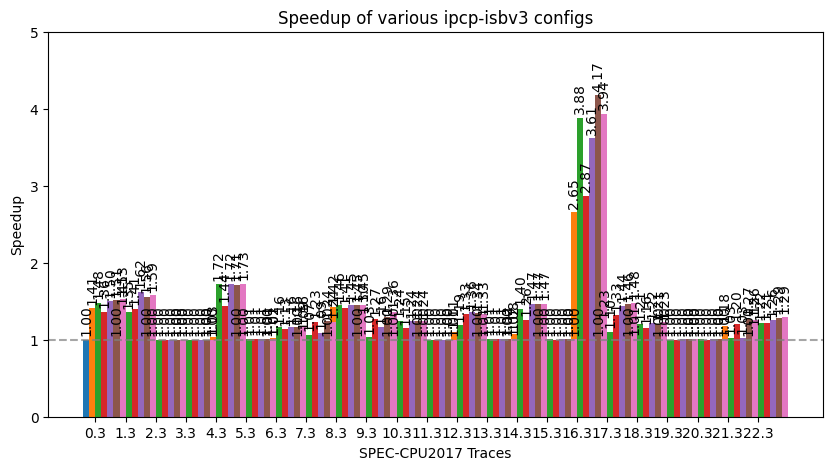

In [18]:
plot(speedups_v3, configs_v3 ,trace_names_v3, "SPEC-CPU2017 Traces", "Speedup", "Speedup of various ipcp-isbv3 configs")

#### For ISB at L1

In [14]:
base_dir_l1 = "../logs/COMP/isb-l1/"
# Define trace names and configuration labels
trace_names = ['450.soplex-247B', '471.omnetpp-188B', '482.sphinx3-234B', '602.gcc_s-2226B']
configs_l1 = ['isb-l1-all', 'isb-l1-miss-pf' ,'isb-l1-miss-stream','isb-l1-miss-train']

ipc_values_l1 = parse_logs(base_dir_l1, trace_names, configs_l1, extract_ipc)

#### For ISB at L2

In [23]:
base_dir_l2 = "../logs/COMP/isb-l2/"
configs_l2 = ['isb-all', 'isb-miss-pf' ,'isb-miss-stream','isb-miss-train']

ipc_values_l2 = parse_logs(base_dir_l2, trace_names, configs_l2, extract_ipc)

In [24]:
ipc_values_l1['450.soplex-247B']['baseline'] = 0.26592
ipc_values_l1['471.omnetpp-188B']['baseline'] = 0.225573
ipc_values_l1['602.gcc_s-2226B']['baseline'] = 0.0980601
ipc_values_l1['482.sphinx3-234B']['baseline'] = 0.564899

ipc_values_l2['450.soplex-247B']['baseline'] = 0.26592
ipc_values_l2['471.omnetpp-188B']['baseline'] = 0.225573
ipc_values_l2['602.gcc_s-2226B']['baseline'] = 0.0980601
ipc_values_l2['482.sphinx3-234B']['baseline'] = 0.564899

In [15]:
def calc_speedup(ipc_values, trace_names, configs):
    speedups = {trace: {} for trace in trace_names}
    for trace in trace_names:
        baseline_ipc = ipc_values[trace]['baseline']
        for config in configs:  # Skip baseline
            speedups[trace][config] = ipc_values[trace][config] / baseline_ipc
    # Calculate geometric mean for each configuration (excluding baseline)
    geomeans = {}
    for config in configs:
        config_speedups = [speedups[trace][config] for trace in trace_names]
        geomeans[config] = gmean(config_speedups)  # Use scipy's gmean for geometric mean

    speedups['Geomean'] = geomeans
    return speedups

In [26]:
speedups_l1 = calc_speedup(ipc_values_l1, trace_names, configs_l1)
speedups_l2 = calc_speedup(ipc_values_l2, trace_names, configs_l2)
trace_names += ['Geomean']

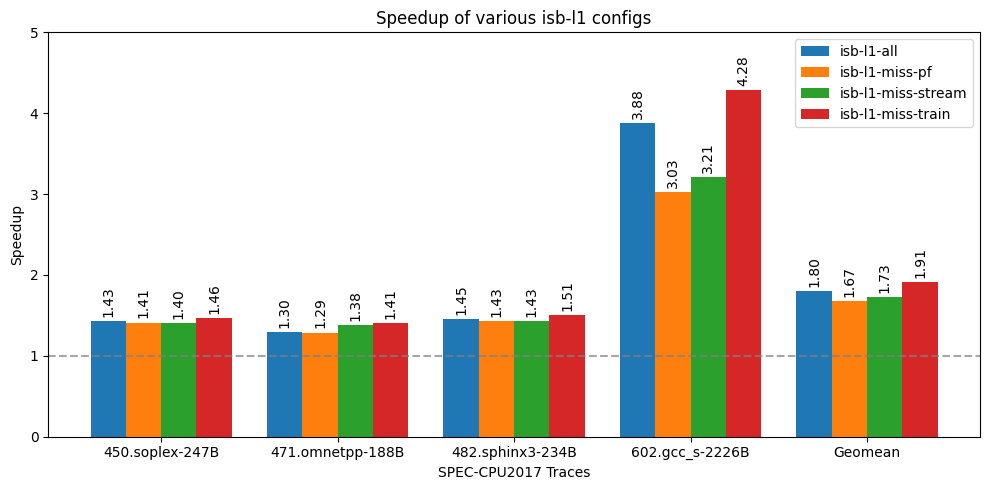

In [27]:
plot(speedups_l1, configs_l1 ,trace_names, "SPEC-CPU2017 Traces", "Speedup", "Speedup of various isb-l1 configs")

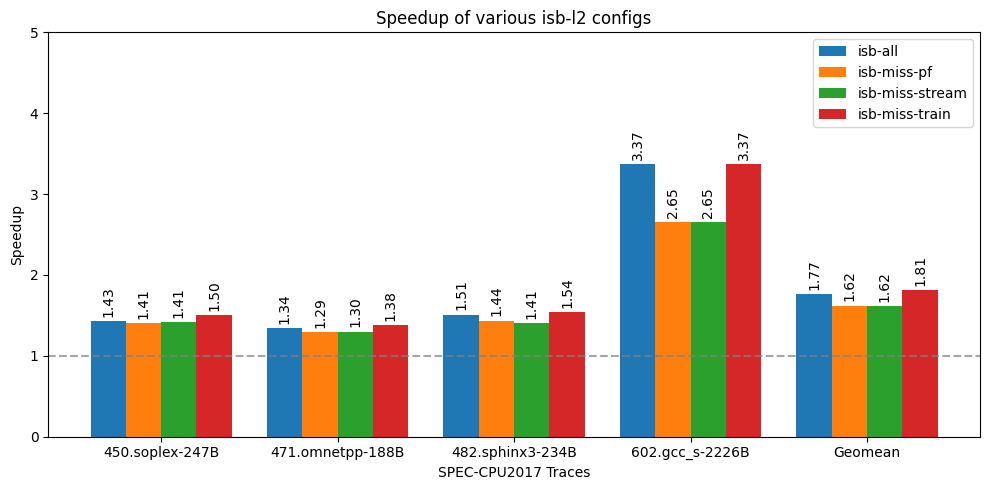

In [28]:
plot(speedups_l2, configs_l2 ,trace_names, "SPEC-CPU2017 Traces", "Speedup", "Speedup of various isb-l2 configs")

#### V3 IPC

In [ ]:
base_dir = "../clean/v3"
# Define trace names and configuration labels
trace_names = ['429.mcf-184B', '450.soplex-247B', '462.libquantum-714B', 
'471.omnetpp-188B', '482.sphinx3-234B','602.gcc_s-2226B', '623.xalancbmk_s-10B']
configs = ['baseline', 'ipcp', 'ipcp_isbv3-all-pf-all-train', 'ipcp_isbv3-all-pf-miss-train', 'isb']

# Initialize a dictionary to store IPC values for each trace and configuration
ipc_values_v3 = {trace: {} for trace in trace_names}
